---
# **Sentiment Analysis**
---

In [1]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import plot_model


# Data analysis
from keras.layers.merge import Concatenate
from collections import Counter
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.models import Model
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.utils import plot_model
import pandas as pd
import numpy as np
import sys
import re

%matplotlib inline

# Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

import sys
import logging
from psutil import virtual_memory

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
ram_gb = virtual_memory().total / 1e9

In [3]:
tf_response = {
    'error': None,
    'TF version': '',
    'COLAB': None,
    'GPU': False,
    'ram_gb': ''
}

In [4]:
try:
    # drive
    from google.colab import drive
    IN_COLAB = 'google.colab' in sys.modules

    # updating tensorflow version
    %tensorflow_version 2.x

    # tensorflow-gpu & tensorflowjs
    !pip install tensorflow-gpu # !pip install tensorflow_text # I could use BERT
    !pip install tensorflowjs

    # NLP (nltk, stanza, spacy)
    !pip install nltk
    !pip install stanza
    !pip install spacy
    !spacy download en_core_web_sm # sm md lg
    !python -m spacy download en
except OSError as error:
    # debugging error
    response['error'] = logging.debug('You are not using your specify version of TensorFlow')
    IN_COLAB = False
    
    # install requirements
    !pip install -r '../requirements.txt'
finally:
    tf_response['COLAB'] = IN_COLAB
    
    # Importing tensroflow core
    import tensorflow as tf
    import tensorflowjs as tfjs
    from tensorflow import keras
    from keras.utils import to_categorical
    from sklearn import preprocessing

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPool1D

    from sklearn.model_selection import train_test_split
    
    # GPU and RAM response
    if tf.config.list_physical_devices('GPU'):
        GPU = True
        tf_response['GPU'] = GPU
        tf_response['TF_version'] = tf.__version__
        
        if tf_response['COLAB'] == True:
            if gpu_info.find('failed') >= 0:
                print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator')
                print('Re-execute this cell.')
            else:
                print(gpu_info)
            
            if ram_gb < 20:
                print('To enable a high-RAM runtime, select the Runtime > "Change runtime type menu"')
                print('Select high-RAM in the runtime shape dropdown')
                print('Re-execute this cell')
                tf_response['ram_gb'] = 'low-RAM runtime'
            else:
                tf_response['ram_gb'] = 'high-RAM runtime'
            print('\nRuntime {:.2f} GB of available RAM\n'.format(ram_gb))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Sun Oct 25 09:16:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off

In [5]:
tf_response

{'COLAB': True,
 'GPU': True,
 'TF version': '',
 'TF_version': '2.3.1',
 'error': None,
 'ram_gb': 'high-RAM runtime'}

In [6]:
! pip install glove_python

## ii. Importing modules


In [7]:
# Data analysis
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import re

%matplotlib inline

# Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from PIL import Image # Pillow with WordCloud to image manipulation

#embeddings 
import glove

#models and metrics
from sklearn.model_selection import *
from sklearn.metrics import *

from sklearn.metrics import confusion_matrix, accuracy_score

---
# **4. Parameters**
---

In [8]:
#dimension of our embedding
EMBEDDING_DIM=50
#features needed from the dataset
features = ["Valence","Arousal","Dominance"]
#classes
main_labels = ['confident', 'unconfident', 
               'pos_hp', 'neg_hp', 
               'interested', 'uninterested', 
               'happy', 'unhappy', 
               'friendly', 'unfriendly'
               ]
               
label_dict = dict(zip(main_labels, range(0, len(main_labels) )))

#inverting label_dict
inv_label = {v: k for k, v in label_dict.items()}

#number of inputs = length features
NUM_INP = len(features)

#number of class
NUM_CLASSES = len(main_labels)

epochs = 200 #60
batch_size = 64

---
# **4. Load dataset**
---

In [9]:
def load_clean_dataset():
    """
    function that loads the dataframe

    return : df -> dataframe
    """
    !mkdir -p datasets
    !wget -nc https://raw.githubusercontent.com/Y4rd13/sentiment-analysis/master/datasets/results/categories_dataset_min_counter.csv -P datasets
    df = pd.read_csv('./datasets/categories_dataset_min_counter.csv', encoding='utf-8', index_col=0)

    return df

In [10]:
df = load_clean_dataset()

File ‘datasets/categories_dataset_min_counter.csv’ already there; not retrieving.



Loading the Glove Embeddings

In [11]:
import os, requests, shutil

glove_dir = './data/RNN/'
glove_100k_50d = 'glove.first-100k.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)

# These are temporary files if we need to download it from the original source (slow)
data_cache = './data/cache'
glove_full_tar = 'glove.6B.zip'
glove_full_50d = 'glove.6B.50d.txt'

#force_download_from_original=False
download_url= 'http://redcatlabs.com/downloads/deep-learning-workshop/notebooks/data/RNN/'+glove_100k_50d
original_url = 'http://nlp.stanford.edu/data/'+glove_full_tar

if not os.path.isfile( glove_100k_50d_path ):
    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)
    
    # First, try to download a pre-prepared file directly...
    response = requests.get(download_url, stream=True)
    if response.status_code == requests.codes.ok:
        print("Downloading 42Mb pre-prepared GloVE file from RedCatLabs")
        with open(glove_100k_50d_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    else:
        # But, for some reason, RedCatLabs didn't give us the file directly
        if not os.path.exists(data_cache):
            os.makedirs(data_cache)
        
        if not os.path.isfile( os.path.join(data_cache, glove_full_50d) ):
            zipfilepath = os.path.join(data_cache, glove_full_tar)
            if not os.path.isfile( zipfilepath ):
                print("Downloading 860Mb GloVE file from Stanford")
                response = requests.get(download_url, stream=True)
                with open(zipfilepath, 'wb') as out_file:
                    shutil.copyfileobj(response.raw, out_file)
            if os.path.isfile(zipfilepath):
                print("Unpacking 50d GloVE file from zip")
                import zipfile
                zipfile.ZipFile(zipfilepath, 'r').extract(glove_full_50d, data_cache)

        with open(os.path.join(data_cache, glove_full_50d), 'rt') as in_file:
            with open(glove_100k_50d_path, 'wt') as out_file:
                print("Reducing 50d GloVE file to first 100k words")
                for i, l in enumerate(in_file.readlines()):
                    if i>=100000: break
                    out_file.write(l)
    
        # Get rid of tarfile source (the required text file itself will remain)
        #os.unlink(zipfilepath)
        #os.unlink(os.path.join(data_cache, glove_full_50d))

print("GloVE available locally")

GloVE available locally


In [12]:
# Due to size constraints, only use the first 100k vectors (i.e. 100k most frequently used words)
word_embedding = glove.Glove.load_stanford( glove_100k_50d_path )
word_embedding.word_vectors.shape

(100000, 50)

In [13]:
def get_embedding_vec(word):
    """
    return : embedding vector of a word
    """
    idx = word_embedding.dictionary.get(word.lower(), -1)
    if idx<0:
        #print("Missing word : '%s'" % (word,))
        return np.zeros(  (EMBEDDING_DIM, ), dtype='float32')  # UNK
    return word_embedding.word_vectors[idx]

In [14]:
def prepare_x_y(df,features):
  """
  function that creates X (features) and Y (labels)

  return : x,y
  """
  embedding_features =[]
  for word in df["word"]:
    embedding_features.append(get_embedding_vec(word))

  feats_without_embedding = df[features]
  y = np.array(list(map(lambda x: label_dict[x.replace(' ', '_')], df["category"])))

  x = np.concatenate((feats_without_embedding,embedding_features),axis=1)

  return x,y

---
# **4. Training Neural Nets**
---

Preparation of X (features) and Y (labels) 

In [15]:
x, y = prepare_x_y(df, features)

Creating our model

In [16]:
# define baseline model
def baseline_model():
	# create model
  input_1 = Input(shape=(NUM_INP+EMBEDDING_DIM,)) 

  dense_layer_1 = Dense(64, activation='relu')(input_1)

  output = Dense(NUM_CLASSES, activation='softmax')(dense_layer_1)
  model = Model(inputs=input_1, outputs=output)
  
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy']) # categorical_accuracy
  model.summary()

  return model

Here we do the stratified train and test split to concerve the distribution :

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
val_data = (X_test,y_test)

In [18]:
def train(model,X_train,y_train,val_data,batch_size,epochs):

  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=5)
  mc = tf.keras.callbacks.ModelCheckpoint('tfjsmodel.h5', monitor='accuracy', #categorical_accuracy 
                                          mode = 'max', verbose=1, save_best_only=True)

  history = model.fit(x=X_train, y=y_train, batch_size=batch_size, callbacks = [mc, es],epochs=epochs, verbose=1, validation_data=val_data)

  return history

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3456      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 4,106
Trainable params: 4,106
Non-trainable params: 0
_________________________________________________________________


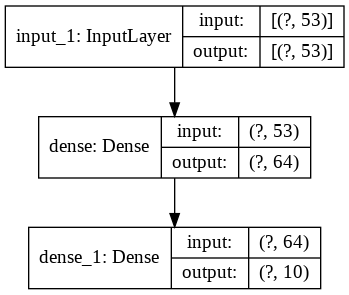

In [19]:
#X1_train,y_train,y_test, X1_test,X2_train,X2_test,maxlen,vocab_size,tokenizer, y_test_labels = preprocessing(X, y, maxlen) #preprocess dataset

#embedding_matrix = GloVe(vocab_size, tokenizer) #glove
def plot_history(history, string):
    fitModel_dict = history.history

    plt.figure(figsize=(10, 6))
    plt.plot(fitModel_dict[string])
    plt.plot(fitModel_dict['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()
model = baseline_model() #building model

plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [20]:
history = train(model,X_train, y_train,val_data, batch_size, epochs)

Epoch 1/200
406/409 [============================>.] - ETA: 0s - loss: 2.3330 - accuracy: 0.1295
Epoch 00001: accuracy improved from -inf to 0.12978, saving model to tfjsmodel.h5
409/409 [==============================] - 1s 3ms/step - loss: 2.3323 - accuracy: 0.1298 - val_loss: 2.2336 - val_accuracy: 0.1702
Epoch 2/200
386/409 [===========================>..] - ETA: 0s - loss: 2.1642 - accuracy: 0.2030
Epoch 00002: accuracy improved from 0.12978 to 0.20400, saving model to tfjsmodel.h5
409/409 [==============================] - 1s 2ms/step - loss: 2.1602 - accuracy: 0.2040 - val_loss: 2.1076 - val_accuracy: 0.2224
Epoch 3/200
397/409 [============================>.] - ETA: 0s - loss: 2.0461 - accuracy: 0.2472
Epoch 00003: accuracy improved from 0.20400 to 0.24786, saving model to tfjsmodel.h5
409/409 [==============================] - 1s 3ms/step - loss: 2.0449 - accuracy: 0.2479 - val_loss: 2.0054 - val_accuracy: 0.2551
Epoch 4/200
394/409 [===========================>..] - ETA: 0s -

In [21]:
def plot_history(history, string):
    fitModel_dict = history.history
    
    plt.figure(figsize=(10, 6))
    plt.plot(fitModel_dict[string])
    plt.plot(fitModel_dict['val_' + string])
    
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

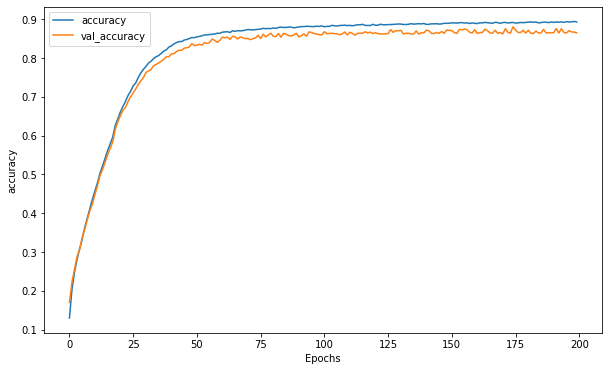

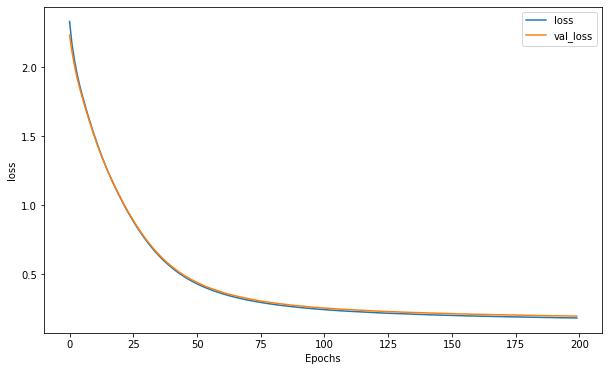

In [22]:
plot_history(history, 'accuracy')
plot_history(history, 'loss')

In [23]:
from keras.models import load_model

In [24]:
test_model = load_model('tfjsmodel.h5')
prediction = test_model.predict(x=X_test, verbose = 1)

205/205 [==============================] - 0s 929us/step


In [25]:
[inv_label[np.argmax(p)] for p in prediction]

['neg_hp',
 'confident',
 'confident',
 'unfriendly',
 'happy',
 'confident',
 'uninterested',
 'pos_hp',
 'friendly',
 'happy',
 'pos_hp',
 'unfriendly',
 'happy',
 'unhappy',
 'unfriendly',
 'friendly',
 'friendly',
 'interested',
 'happy',
 'unhappy',
 'pos_hp',
 'friendly',
 'unhappy',
 'happy',
 'neg_hp',
 'unconfident',
 'unfriendly',
 'happy',
 'unfriendly',
 'happy',
 'pos_hp',
 'happy',
 'unfriendly',
 'interested',
 'confident',
 'interested',
 'uninterested',
 'friendly',
 'happy',
 'unconfident',
 'neg_hp',
 'pos_hp',
 'happy',
 'friendly',
 'friendly',
 'pos_hp',
 'neg_hp',
 'uninterested',
 'pos_hp',
 'unconfident',
 'neg_hp',
 'interested',
 'uninterested',
 'friendly',
 'interested',
 'unhappy',
 'friendly',
 'friendly',
 'neg_hp',
 'pos_hp',
 'pos_hp',
 'uninterested',
 'uninterested',
 'happy',
 'confident',
 'friendly',
 'friendly',
 'happy',
 'unfriendly',
 'unfriendly',
 'pos_hp',
 'unhappy',
 'friendly',
 'neg_hp',
 'interested',
 'friendly',
 'interested',
 'unin

In [26]:
y_classes = prediction.argmax(axis=-1)

In [27]:
test_score = model.evaluate(x=X_test, y=y_test, verbose=1)

205/205 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.8651


In [28]:
test_score

[0.1968691349029541, 0.8651255369186401]

---
# **4. Prediction**
---

In [29]:
def predict_class(word,valence,arousal,dominance):
  """
  a function that predicts sentiments from words

  ARGUMENTS : 

  word : our word (exple happy, tolerant ..)

  valence,arousal,dominance,quadrant : important features that boost the accuracy of the model

  return : class predicted

  """

  #creating the embedding of the word 
  embedding_features = get_embedding_vec(word)


  feats_without_embedding = [valence, arousal, dominance]

  #creating our X that contains all features (word_embeddings, VADQ)
  x_t = np.concatenate((feats_without_embedding,embedding_features)).reshape(1,53) # 54 if we are using quadrant as parameter
  
  #predictions (we will take saved models of each fold and do an average of predictions)
  model = load_model('tfjsmodel.h5')
  prediction = model.predict(x=x_t, verbose = 1)

  return inv_label[np.argmax(prediction)]

In [30]:
predict_class("enablement", 0.76, 0.491, 0.782)

1/1 [==============================] - 0s 1ms/step


'pos_hp'

In [31]:
predict_class("kill", 0.076, 0.091, 0.082)

1/1 [==============================] - 0s 1ms/step


'unhappy'